<a href="https://colab.research.google.com/github/saai07/LLM_finetuning/blob/main/gemma-3-270m-it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!pip install trl accelerate gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.8/528.8 kB 14.0 MB/s eta 0:00:00


In [3]:
import transformers
import trl
import datasets
import accelerate
import torch
import gradio as gr

In [4]:
if torch.cuda.is_available():
  device = torch.cuda.current_device()
  gpu_name = torch.cuda.get_device_name(device)

  total_memory = torch.cuda.get_device_properties(device).total_memory
  print(f"GPU: {gpu_name}")
  print(f"Total Memory:     {total_memory / 1e6:.2f} MB | {total_memory / 1e9:.2f} GB")
else:
  print("no gpu available")

GPU: Tesla T4
Total Memory:     15637.09 MB | 15.64 GB


# Setup of Base model

In [7]:
from huggingface_hub import notebook_login

notebook_login()


In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM


model_name = "google/gemma-3-270m-it"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    attn_implementation = "eager",

)

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Gemma requires numbers as token as imput

turn strings into tokens via a tokenizer!

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"[INFO] Model on device: {model.device}")
print(f"[INFO] Model using dtype: {model.dtype}")

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

[INFO] Model on device: cuda:0
[INFO] Model using dtype: torch.bfloat16


In [10]:
tokenizer(" hello i am sai ")

{'input_ids': [2, 29104, 858, 1006, 44951, 236743], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [11]:
outputs = model(torch.tensor(tokenizer("Hello my name is Sai")["input_ids"]).unsqueeze(0).to("cuda"))
outputs.keys()


odict_keys(['logits', 'past_key_values'])

#Loading dataset

In [12]:
from datasets import load_dataset

dataset = load_dataset("mrdbourke/FoodExtract-1k")

print(f"[INFO] Number of sample  in the datasets :{len(dataset["train"])}")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/616k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1420 [00:00<?, ? examples/s]

[INFO] Number of sample  in the datasets :1420


In [13]:
import random
def get_random_id(dataset):
  random_id = random.randint(0, len(dataset)-1)
  return random_id


random_id = get_random_id(dataset["train"])
random_sample = dataset["train"][random_id]

In [14]:
example_input = random_sample['sequence']
example_output = random_sample['gpt-oss-120b-label']
example_output_condensed = random_sample['gpt-oss-120b-label-condensed']
print(f"[INFO] Input:\n{example_input}")
print()
print(f"[INFO] Example structured output (what we want our model to learn to predict):")
print(eval(example_output))
print()
print(f"[INFO] Example output condensed (we'll train our model to predict the condensed output since it uses less tokens than JSON):")
print(example_output_condensed)

[INFO] Input:
A top‑down view of a pristine white plate presents an artful arrangement of individual components: a small pile of brown sugar scattered near the edge, a round corn tortilla resting beside it, fresh tarragon leaves fanned out in a bright green cluster, a dollop of creamy tzatziki sauce in a shallow well, several crisp snow peas laid side by side, a few peeled garlic cloves beside the peas, thin strips of seasoned beef arranged in a neat line, a split English muffin showing its soft interior, a slab of raw pork belly with its pink flesh and fat layers visible, two soft bao buns placed next to the pork, a drizzle of Worcestershire sauce in a tiny drizzle pattern, and a spoonful of smooth macadamia butter placed in a small circle.

[INFO] Example structured output (what we want our model to learn to predict):
{'is_food_or_drink': True, 'tags': ['fi'], 'food_items': ['brown sugar', 'corn tortilla', 'tarragon leaves', 'tzatziki sauce', 'snow peas', 'garlic cloves', 'seasoned b

In [15]:
# Our fine-tuned model will assign tags to text so we can easily filter them by type in the future
tags_dict = {'np': 'nutrition_panel',
 'il': 'ingredient list',
 'me': 'menu',
 're': 'recipe',
 'fi': 'food_items',
 'di': 'drink_items',
 'fa': 'food_advertistment',
 'fp': 'food_packaging'}

# Format the dataset into LLM-style inputs/outputs

In [16]:
random_sample

{'sequence': 'A top‑down view of a pristine white plate presents an artful arrangement of individual components: a small pile of brown sugar scattered near the edge, a round corn tortilla resting beside it, fresh tarragon leaves fanned out in a bright green cluster, a dollop of creamy tzatziki sauce in a shallow well, several crisp snow peas laid side by side, a few peeled garlic cloves beside the peas, thin strips of seasoned beef arranged in a neat line, a split English muffin showing its soft interior, a slab of raw pork belly with its pink flesh and fat layers visible, two soft bao buns placed next to the pork, a drizzle of Worcestershire sauce in a tiny drizzle pattern, and a spoonful of smooth macadamia butter placed in a small circle.',
 'image_url': None,
 'class_label': 'food',
 'source': 'gpt-oss-120b',
 'char_len': 737.0,
 'word_count': 131.0,
 'syn_or_real': 'syn',
 'uuid': '7203b479-c819-462c-89ae-d0dbfb2ade92',
 'gpt-oss-120b-label': "{'is_food_or_drink': True, 'tags': ['

In [17]:
def sample_to_conversation(sample):
    """Helper function to convert an input sample to conversation style."""
    return {
        "messages": [
            {"role": "user", "content": sample["sequence"]}, # Load the sequence from the dataset
            {"role": "system", "content": sample["gpt-oss-120b-label-condensed"]} # Load the gpt-oss-120b generated label
        ]
    }

sample_to_conversation(random_sample)

{'messages': [{'role': 'user',
   'content': 'A top‑down view of a pristine white plate presents an artful arrangement of individual components: a small pile of brown sugar scattered near the edge, a round corn tortilla resting beside it, fresh tarragon leaves fanned out in a bright green cluster, a dollop of creamy tzatziki sauce in a shallow well, several crisp snow peas laid side by side, a few peeled garlic cloves beside the peas, thin strips of seasoned beef arranged in a neat line, a split English muffin showing its soft interior, a slab of raw pork belly with its pink flesh and fat layers visible, two soft bao buns placed next to the pork, a drizzle of Worcestershire sauce in a tiny drizzle pattern, and a spoonful of smooth macadamia butter placed in a small circle.'},
  {'role': 'system',
   'content': 'food_or_drink: 1\ntags: fi\nfoods: brown sugar, corn tortilla, tarragon leaves, tzatziki sauce, snow peas, garlic cloves, seasoned beef, English muffin, pork belly, bao buns, Wo

In [23]:
dataset = dataset.map(sample_to_conversation , batched = False)

dataset["train"][42]

Map:   0%|          | 0/1420 [00:00<?, ? examples/s]

{'sequence': 'another optional quest takes place on windfall island during the night time play the song of passing a number of times and each time, glance towards the sky',
 'image_url': 'https://portforward.com/games/walkthroughs/The-Legend-of-Zelda-The-Wind-Waker/The-Legend-of-Zelda-The-Wind-Waker-large-430.jpg',
 'class_label': 'not_food',
 'source': 'qwen2vl_open_dataset',
 'char_len': 156.0,
 'word_count': 28.0,
 'syn_or_real': 'real',
 'uuid': 'bbac79ce-df1f-48b8-891c-752809be11c7',
 'gpt-oss-120b-label': "{'is_food_or_drink': 'false', 'tags': [], 'food_items': [], 'drink_items': []}",
 'gpt-oss-120b-label-condensed': 'food_or_drink: 0\ntags: \nfoods: \ndrinks:',
 'target_food_names_to_use': None,
 'caption_detail_level': None,
 'num_foods': None,
 'target_image_point_of_view': None,
 'messages': [{'content': 'another optional quest takes place on windfall island during the night time play the song of passing a number of times and each time, glance towards the sky',
   'role': 'u

In [25]:
dataset = dataset["train"].train_test_split(test_size = 0.3, shuffle=False , seed = 42)

dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 994
    })
    test: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 426
    })
})

# Trying the model with pipeline

In [28]:
easy_sample = {"role":"user",
               "content":" hello i a sai"}
def simple_input(input):
  template = {"role":"user" ,"content": input}
  return template

In [37]:
from transformers import pipeline

pipe = pipeline("text-generation",
                model = model,
                tokenizer=tokenizer)

input_text = "hi i am sai , Please respond to me with a machine learning poem"
sample_input = simple_input(input = input_text)
input_prompt = pipe.tokenizer.apply_chat_template([sample_input], tokenize = False , add_generation_prompt = True)
print(f"[INFO] This is the input prompt: {input_prompt}")


default_outputs = pipe(input_prompt,
                       max_new_tokens=512,
                       disable_compile=True)

print(f"[INFO] Input:\n{input_text}")
print()
print(f"[INFO] Output from {model_name}:")
print()
print(default_outputs[0]["generated_text"][len(input_prompt):])

Both `max_new_tokens` (=512) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] This is the input prompt: <bos><start_of_turn>user
hi i am sai , Please respond to me with a machine learning poem<end_of_turn>
<start_of_turn>model

[INFO] Input:
hi i am sai , Please respond to me with a machine learning poem

[INFO] Output from google/gemma-3-270m-it:

Okay, I'm ready! Let's create a machine learning poem. I'll aim for something evocative and engaging. 

**A Symphony of Data, a Symphony of Thoughts**

The data streams, a torrent bright,
Unraveling patterns, day and night.
Each data point, a story untold,
Of hopes and fears, brave and bold.

Patterns bloom, a digital bloom,
Where logic reigns, dispelling gloom.
Connections weave, a web so deep,
Connecting seeds, secrets to keep.

From simple data, a complex art,
A tapestry of thought, a beating heart.
Binary code, a coded plea,
To understand, to truly be.

The algorithms learn and grow,
Unraveling truths, in steady flow.
With every iteration, it's true,
A learning process, fresh and new.

The future waits, a b

In [44]:
random_id = get_random_id(dataset=dataset["train"])
random_sample = dataset["train"][random_id]
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_sample["messages"][:1],
                                                  tokenize = False,
                                                  add_generation_prompt = True)
print(f"[INFO] This is the input prompt: {input_prompt}")


default_outputs = pipe(text_inputs=input_prompt, max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]["generated_text"][len(input_prompt):]}")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] This is the input prompt: <bos><start_of_turn>user
A top‑down view of a pristine white plate reveals each component arranged with care: a generous dollop of smooth, ivory‑colored cream sour placed in the lower left corner, its surface lightly speckled with a fine drizzle of golden olive oil that catches the light; beside it, two perfectly assembled eggs benedict sit on toasted English muffin halves, the poached eggs centered and their yolks glistening like amber pearls; a bright cluster of deep‑purple acai berries rests nearby, their glossy skins contrasting with the plate; scattered across the plate are delicate zucchini flowers, their pale green petals unfurled and veined with subtle yellow centers; a slim, clear glass of frothy root beer stands upright at the edge of the composition, the dark liquid capped with a creamy head; a small mound of dukkah spice, a golden‑brown blend of toasted nuts, seeds, and herbs, occupies the upper right, its texture coarse and inviting; a neat

# Trying to prompt the model

In [52]:
prompt_instruction = """Given the following target input text from an image caption, please extract the food and drink items to a list.
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Sai. I am a machine learning engineer
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: <targ_input_text>"""

def update_input_message_content(input):
    original_content = input["messages"][:1][0]["content"]
    new_content = prompt_instruction.replace("<targ_input_text>", original_content)

    new_input = [{"content": new_content,
                  "role": "user"}]

    return new_input

print(f'[INFO] Original content:\n{random_sample["messages"][:1][0]["content"]}')
print()
print(f'[INFO] New content with instructions in prompt:')
print(update_input_message_content(input=random_sample)[0]["content"])

[INFO] Original content:
A top‑down view of a pristine white plate reveals each component arranged with care: a generous dollop of smooth, ivory‑colored cream sour placed in the lower left corner, its surface lightly speckled with a fine drizzle of golden olive oil that catches the light; beside it, two perfectly assembled eggs benedict sit on toasted English muffin halves, the poached eggs centered and their yolks glistening like amber pearls; a bright cluster of deep‑purple acai berries rests nearby, their glossy skins contrasting with the plate; scattered across the plate are delicate zucchini flowers, their pale green petals unfurled and veined with subtle yellow centers; a slim, clear glass of frothy root beer stands upright at the edge of the composition, the dark liquid capped with a creamy head; a small mound of dukkah spice, a golden‑brown blend of toasted nuts, seeds, and herbs, occupies the upper right, its texture coarse and inviting; a neat portion of pad see ew noodles li

In [49]:
# Apply the chat template
updated_input_prompt = update_input_message_content(input=random_sample)

input_prompt = pipe.tokenizer.apply_chat_template(conversation=updated_input_prompt,
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt,
                       max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Input:
<bos><start_of_turn>user
Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Sai. I am a machine learning engineer
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: A top‑down view of a pristine white plate reveals each component arranged with care: a generous dollop of smooth, ivory‑colored cream sour placed in the lower left corner, its surface lightly speckled with a fine drizzle of golden olive oil that catches the light; beside 

In [51]:
# This is our input
print(random_sample["messages"][0]["content"])
print()

# This is our ideal output:
print(random_sample["messages"][1]["content"])

A top‑down view of a pristine white plate reveals each component arranged with care: a generous dollop of smooth, ivory‑colored cream sour placed in the lower left corner, its surface lightly speckled with a fine drizzle of golden olive oil that catches the light; beside it, two perfectly assembled eggs benedict sit on toasted English muffin halves, the poached eggs centered and their yolks glistening like amber pearls; a bright cluster of deep‑purple acai berries rests nearby, their glossy skins contrasting with the plate; scattered across the plate are delicate zucchini flowers, their pale green petals unfurled and veined with subtle yellow centers; a slim, clear glass of frothy root beer stands upright at the edge of the composition, the dark liquid capped with a creamy head; a small mound of dukkah spice, a golden‑brown blend of toasted nuts, seeds, and herbs, occupies the upper right, its texture coarse and inviting; a neat portion of pad see ew noodles lies in a compact nest, the

# Fine-tuning our model


In [60]:
from trl import SFTConfig

torch_dtype = model.dtype

Check_point_dir = "./checkpoint_model"

base_learning_point = 5e-5


stf_config = SFTConfig(
    output_dir = Check_point_dir,
    max_length = 256,
    packing = False,
    num_train_epochs = 4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    optim = "adamw_torch_fused",
    logging_steps = 1,
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate = base_learning_point,
    gradient_checkpointing = False,
    fp16=True if torch_dtype == torch.float16 else False,
    bf16=True if torch_dtype == torch.float16 else False,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to=None
)

In [61]:
from trl import SFTTrainer

#create Trainer object

trainer = SFTTrainer(
    model=model,
    args = stf_config,
    train_dataset = dataset["train"],
    eval_dataset = dataset["test"],
    processing_class = tokenizer)

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss
1,1.975932,2.312394
2,2.554789,2.342454
3,2.114757,2.458777


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=375, training_loss=1.9970282508532207, metrics={'train_runtime': 744.1676, 'train_samples_per_second': 4.007, 'train_steps_per_second': 0.504, 'total_flos': 433012302008832.0, 'train_loss': 1.9970282508532207})

# Plotting

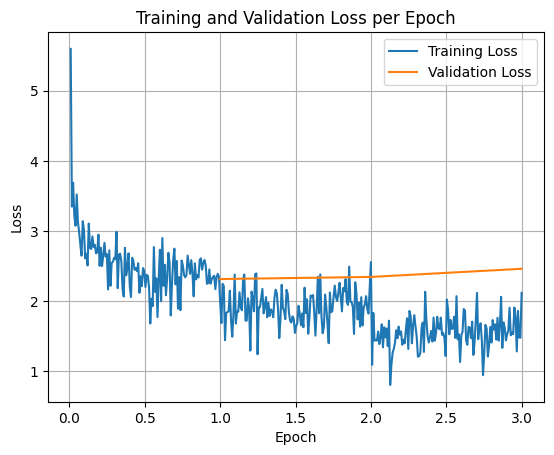

In [62]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()



In [63]:
trainer.save_model()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
# Remove all the checkpoint folders (since we've already saved the best model)
!rm -rf ./checkpoint_models/checkpoint-*/*
!rm -rf ./checkpoint_models/checkpoint-*

In [68]:
Check_point_dir

'./checkpoint_model'

In [69]:
# Load the fine-tuned model and see how it goes
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load trained model
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=Check_point_dir,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)

loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

loaded_model_pipeline

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

TextGenerationPipeline: {'model': 'Gemma3ForCausalLM', 'dtype': 'bfloat16', 'device': 'cuda', 'input_modalities': ('image', 'text'), 'output_modalities': ('text',)}

In [70]:
dataset["test"]

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 426
})

In [74]:
# Get a random sample
random_test_idx = get_random_id(dataset["test"])
random_test_sample = dataset["test"][random_test_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_test_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = loaded_model_pipeline(text_inputs=input_prompt,
                                        max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Input:
<bos><start_of_turn>user
A blue package of Menz Compound Chocolate with ingredients including sugar, vegetable oil, milk solids, cocoa powder, and soy lecithin. The package is gluten-free and contains milk and soy. It also mentions that peanuts and almonds may be present. The nutrition information shows 6 servings per package, with each serving size being 25g. Per serving, the energy is 462kJ, protein is 0.6g, total fat is 4.4g, saturated fat is 4.1g, carbohydrates are 17.4g, sugars are 15.0g, and sodium is 77mg. The package is labeled as Australian-made and owned.<end_of_turn>
<start_of_turn>model


[INFO] Output:
food_or_drink: 1
tags: np, di, fp
foods: Menz Compound Chocolate, sugar, vegetable oil, milk solids, cocoa powder, soy lecithin, peanuts, almonds
drinks:


In [75]:
print(random_test_sample["gpt-oss-120b-label-condensed"])

food_or_drink: 1
tags: np, il, fi, fp
foods: Menz Compound Chocolate, sugar, vegetable oil, milk solids, cocoa powder, soy lecithin, milk, soy, peanuts, almonds
drinks:


In [76]:
def get_model_num_params(model):
    """
    Returns the number of trainable, non-trainable and total parameters of a PyTorch model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    return {"trainable_params": trainable_params,
            "non_trainable_params": non_trainable_params,
            "total_params": total_params}

# Get parameters of our fine-tuned model
model_params = get_model_num_params(loaded_model)
print(f"Trainable parameters: {model_params['trainable_params']:,}")
print(f"Non-trainable parameters: {model_params['non_trainable_params']:,}")
print(f"Total parameters: {model_params['total_params']:,}")

Trainable parameters: 268,098,176
Non-trainable parameters: 0
Total parameters: 268,098,176


In [77]:
# Our model is 270M parameters, GPT-OSS-120B is 120B parameters
120_000_000_000 / 270_000_000

444.44444444444446

### By fine-tuning Gemma 3 270M we distill the capabilities of a 120B parameter model into a model 444x smaller.

 Uploading our fine-tuned model to the Hugging Face Hub

In [81]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

MODEL_PATH = Check_point_dir # Corrected path to where the model was saved

# Load the model into a pipeline
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=MODEL_PATH,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_PATH
)

# Create a pipeline from the loaded model
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

# Test the loaded model on raw text
test_input_message = "Hello my name is Sai "
loaded_model_pipeline(test_input_message)

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'Hello my name is Sai 2.0.0.9, and I am a student from UC Berkeley. I believe in the power of global cooperation to solve global problems. In my class, we have used the collaborative storytelling project to teach teamwork and communication. Here\'s my presentation: "Global Problem Solving with Collaborative Storytelling: 3.0"'}]

In [82]:
def format_message(input):
    return [{"role": "user", "content": input}]

input_formatted = format_message(input=test_input_message)
input_formatted

[{'role': 'user', 'content': 'Hello my name is Sai '}]

In [83]:
input_prompt = loaded_model_pipeline.tokenizer.apply_chat_template(conversation=input_formatted,
                                                                   tokenize=False,
                                                                   add_generation_prompt=True)

input_prompt

'<bos><start_of_turn>user\nHello my name is Sai<end_of_turn>\n<start_of_turn>model\n'

In [84]:
loaded_model_outputs = loaded_model_pipeline(text_inputs=input_prompt,
                                             max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{loaded_model_outputs[0]['generated_text'][len(input_prompt):]}")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Input:
<bos><start_of_turn>user
Hello my name is Sai<end_of_turn>
<start_of_turn>model


[INFO] Output:
food_or_drink: 0
tags: 
foods: 
drinks:


In [85]:
import time

def pred_on_text(input_text):
    start_time = time.time()

    raw_output = loaded_model_pipeline(text_inputs=[{"role": "user",
                                                    "content": input_text}],
                                       max_new_tokens=256,
                                       disable_compile=True)
    end_time = time.time()
    total_time = round(end_time - start_time, 4)

    generated_text = raw_output[0]["generated_text"][1]["content"]

    return generated_text, raw_output, total_time

pred_on_text(input_text="British Breakfast with baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea and toast and fried tomatoes")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


('food_or_drink: 1\ntags: fi, di\nfoods: baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea, toast, fried tomatoes\ndrinks:',
 [{'generated_text': [{'role': 'user',
     'content': 'British Breakfast with baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea and toast and fried tomatoes'},
    {'role': 'assistant',
     'content': 'food_or_drink: 1\ntags: fi, di\nfoods: baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea, toast, fried tomatoes\ndrinks:'}]}],
 4.2898)

In [86]:
from huggingface_hub import HfApi, create_repo

api = HfApi()

# Give our model a name (this is in the format [Hugging Face Username]/[Target Model Name]
repo_id = "sai237/FoodTagExtract-gemma-3-270m-fine-tune-v1"

# Create the repo
create_repo(repo_id,
            repo_type="model",
            exist_ok=True)

# Upload the entire model folder containing our model files
api.upload_folder(
    folder_path=Check_point_dir,
    repo_id=repo_id,
    repo_type="model"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ckpoint-125/rng_state.pth:  77%|#######7  | 11.3kB / 14.6kB            

  ...kpoint-250/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

  ...kpoint-125/tokenizer.json:  25%|##4       | 8.28MB / 33.4MB            

  ...ckpoint-250/rng_state.pth:  77%|#######7  | 11.3kB / 14.6kB            

  ...eckpoint-125/optimizer.pt:   0%|          | 54.4kB / 1.07GB            

  ...eckpoint-250/scheduler.pt: 100%|##########| 1.47kB / 1.47kB            

  ...eckpoint-250/optimizer.pt:   0%|          | 54.4kB / 1.07GB            

  ...kpoint-375/tokenizer.json:  25%|##4       | 8.28MB / 33.4MB            

  ...eckpoint-375/optimizer.pt:   0%|          | 54.4kB / 1.07GB            

  ...ckpoint-375/rng_state.pth:  77%|#######7  | 11.3kB / 14.6kB            

CommitInfo(commit_url='https://huggingface.co/sai237/FoodTagExtract-gemma-3-270m-fine-tune-v1/commit/66042f6258801df2a315e3fa450f0466b47600b9', commit_message='Upload folder using huggingface_hub', commit_description='', oid='66042f6258801df2a315e3fa450f0466b47600b9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sai237/FoodTagExtract-gemma-3-270m-fine-tune-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='sai237/FoodTagExtract-gemma-3-270m-fine-tune-v1'), pr_revision=None, pr_num=None)